### 2018/2019 - Task List 4 - poisson parameter inference


## Required imports

In [16]:
%matplotlib inline
import pyro
import torch
import numpy as np
import matplotlib.pyplot as plt
import pyro.optim as optim
import pyro.distributions as dist
from torch.distributions import constraints
from tqdm import tqdm
import seaborn as sns
from matplotlib import animation, rc
from IPython.display import HTML
import torch.nn as nn
from functools import partial
import pandas as pd
from pyro.contrib.autoguide import AutoDiagonalNormal
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, TracePredictive

In [17]:
pyro.set_rng_seed(1)
#force pyro to validate
pyro.enable_validation(True)

In [18]:
input_rate=100

In [19]:
with pyro.plate("data", 20000):
    data = pyro.sample("sample", pyro.distributions.Poisson(input_rate))

(array([   25.,   234.,  1436.,  3434.,  5325.,  5568.,  2751.,   959.,
          226.,    42.]),
 array([  64. ,   71.4,   78.8,   86.2,   93.6,  101. ,  108.4,  115.8,
         123.2,  130.6,  138. ]),
 <a list of 10 Patch objects>)

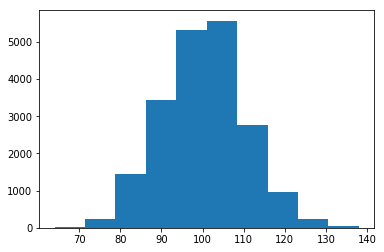

In [20]:
plt.hist(data)

In [21]:
#assume almost no noise in data
noise_std=0.0001
def model(data):  # equivalent to conditioned_scale above
    prio= pyro.distributions.Poisson(1)
    #force pyro to use whole data
    with pyro.plate("map", len(data)):
        weight = pyro.sample("sample",prio)
        pyro.sample("measurement", pyro.distributions.Normal(weight, noise_std), obs=data)

def guide(data):
    rate = pyro.param("rate", torch.tensor(2.), constraint=constraints.positive)
    #force pyro to use whole data
    with pyro.plate("map", len(data)):
        return pyro.sample("sample", pyro.distributions.Poisson(rate))

In [22]:
optim = pyro.optim.Adam({"lr": 0.005})
svi = pyro.infer.SVI(model=model,
                     guide=guide,
                     optim=optim,
                     loss=pyro.infer.Trace_ELBO(), num_samples=len(data))

In [23]:
pyro.clear_param_store()
losses, rate  = [], []
num_steps = 1000
for t in tqdm(range(num_steps)):
    losses.append(svi.step(data))
    rate.append(pyro.param("rate"))

100%|██████████| 1000/1000 [00:08<00:00, 116.62it/s]


learned mean =  tensor(99.5813, grad_fn=<AddBackward0>)


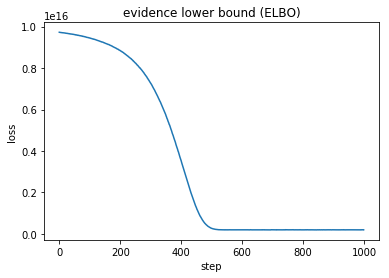

In [24]:
plt.plot(losses)
plt.title("evidence lower bound (ELBO)")
plt.xlabel("step")
plt.ylabel("loss");
print('learned mean = ',pyro.param("rate"))

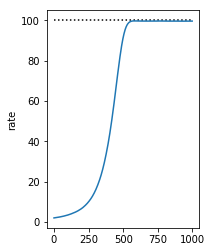

In [25]:

plt.subplot(1,2,1)
plt.plot([0,num_steps],[input_rate,input_rate], 'k:')
plt.plot(rate)
plt.ylabel('rate');

In [26]:
rate[-1]

tensor(99.5813, grad_fn=<AddBackward0>)

(array([  3.00000000e+00,   1.24000000e+02,   1.13000000e+03,
          3.61100000e+03,   5.98200000e+03,   5.90700000e+03,
          2.44000000e+03,   7.05000000e+02,   9.10000000e+01,
          7.00000000e+00]),
 array([  59. ,   67.4,   75.8,   84.2,   92.6,  101. ,  109.4,  117.8,
         126.2,  134.6,  143. ]),
 <a list of 10 Patch objects>)

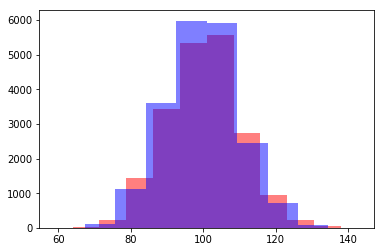

In [27]:
learned_rate=rate[-1]
with pyro.plate("data", 20000):
    learned_sample = pyro.sample("sample", pyro.distributions.Poisson(learned_rate))
plt.hist(data, color='r', alpha=0.5)
plt.hist(learned_sample, color='b', alpha=0.5)

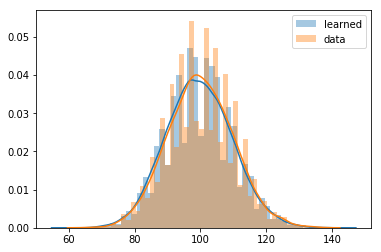

In [28]:
sns.distplot(learned_sample, label="learned");
sns.distplot(data, label="data");
plt.legend();